In [1]:
# A notebook to test our hierarchical sampler. 

In [96]:
import collections
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st

# Numba to make things faster
import numba

# The MCMC Hammer
import emcee

# Numerical differentiation package
import numdifftools as ndt

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner


# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}


# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import datetime as dt
from scipy import stats



In [135]:
def index_maker(df, target, g='gene', d='z_dead'):
    """
    A function to extract data into a flat-array from a dataframe
    and keep track of all indices.
    
    params:
    ------
    df - dataframe to use
    target - list of gene names
    g - name of the column to extract gene names from
    d - column in which the data is contained. 
    """
    if type(target) in [str, int, float]:
        target = [target]
        
    df1 = df[df[g].isin(target)]                                   # cropy by target
    t_list = [group[d].values for name, group in df1.groupby(g)]   # get data and put into list
    t = np.concatenate(t_list)
    n_points = np.array([len(t) for t in t_list])
    inds = np.concatenate(((0,), n_points.cumsum()))               # get indices
    return t, inds

In [389]:
@numba.jit(nopython=True)
def log_posterior_good_bad_numba(p, x):
    """
    The log posterior for the good/bad data model for repeated
    measurements.
    
    params:
    -------
    p - the parameters. First three params must be mu, sigma, and sigma_bad
    x - data to fit the model to
    
    output:
    log_prior + log_like - a scalar number
    """
    # Pull out parameters
    mu, sigma, sigma_bad = p[:3]
    g = p[3:]
        
    if (g < 0.0).any() or (g > 1.0).any() or sigma <= 0.0 \
            or sigma_bad < sigma:
        return -np.inf
    
    if mu > 10**10:
        return -np.inf
    
    # log prior
    log_prior = -np.log(sigma) - np.log(sigma_bad)
    
    # Add in likelihood
    log_like_good = np.log((1-g) / sigma) - ((x - mu) / sigma)**2 / 2.0
    log_like_bad = np.log(g / sigma_bad) \
                        - ((x - mu) / sigma_bad)**2 / 2.0
    log_like = np.logaddexp(log_like_good, log_like_bad).sum()


    #  Return the whole posterior
    return log_prior + log_like - np.sum(g)

@numba.jit(nopython=True)
def log_hyper_good_bad(p, x):
    """
    The log posterior for the good/bad data model for repeated
    measurements.
    
    params:
    -------
    p - the parameters. First three params must be mu, sigma, and sigma_bad
    x - data to fit the model to
    
    output:
    log_prior + log_like - a scalar number
    """
    # Pull out parameters
    mu, sigma, sigma_bad = p[:3]
    g = p[3:]
        
    if (g < 0.0).any() or (g > 1.0).any() or sigma <= 0.0 \
            or sigma_bad < sigma:
        return -np.inf
    
    # log prior
    log_prior = -np.log(sigma) - np.log(sigma_bad)
    
    # Add in likelihood
    log_like_good = np.log((1-g) / sigma) - ((x - mu) / sigma)**2 / 2.0
    log_like_bad = np.log(g / sigma_bad) \
                        - ((x - mu) / sigma_bad)**2 / 2.0
    log_like = np.logaddexp(log_like_good, log_like_bad).sum()


    #  Return the whole posterior
    return log_prior + log_like - np.sum(g)

In [271]:
@numba.jit()
def hierarchical_indexed_log_posterior_numba(P, t, inds, indicator):
    """
    The log posterior for the good/bad data model for repeated
    measurements under different conditions
    
    HyperHyperParameters
    MU = P[0]
    SIGMA = P[1]
    SIGMA_BAD = P[2]
    s = P[3:3+t_len]
    
    Params
    mu = P[start + i]
    sigma = P[start + t_len + i]
    sigma_bad = P[start + 2*t_len + i]
    G = P[start+3*t_len+n_data: start+3*t_len+n_data+data_points]

    params:
    -------
    P - the parameters for all conditions. First n values are
    mu, n-2n are sigma, 2n-3n are sigma_bad. Rest are g's
    df - dataframe containing only the conditions to be used
    g -- string coding the name of the column to groupby
    d -- string coding the name of the column containing the data
    means -- boolean indicating where the means for each rnai are within P
    
    output:
    -------
    log_prior + log_like - a scalar number
    """
    lp = 0
    n_data = 0             # which data point we are on        
    
    for i in range(0, len(inds)-1):   
        #update log posterior
        begin = n_data + 3*i + 3 + len(inds) - 1
        end = n_data + 3*i + 3 + len(inds) - 1\
                + 3 + len(t[inds[i]:inds[i+1]])
        
        lp += log_posterior_good_bad_numba(P[begin:end],
                                     t[inds[i]:inds[i+1]])
        #update the parameter indices
        n_data += len(t[inds[i]:inds[i+1]])  
        
    # posterior for the means. Input the hyperparams, followed by 
    # mean of each gene (of which there are n=t_len)
    lp += log_posterior_good_bad_numba(P[0:3+len(inds) - 1], 
                                       P[indicator]) # hyperhyperposterior

    return lp

In [251]:
@numba.jit(nopython=True)
def neg_log_posterior_good_bad_numba(p, x):
    return -log_posterior_good_bad_numba(p, x)


In [252]:
def make_p0(target, df, g='gene', d='z_dead', n_burn=2000, n_steps=2000):
    """
    A wrapper around the emcee sampler for easy MCMCs.
    Given a set of target genes, calculate the good_bad model for each. 
    
    This wrapper function takes in a dataframe containing information
    on a few different genes. The user must specify which gene is 
    targeted, this gene is then analyzed using a good-bad posterior.

    params:
    -------
    target -- a string that specifies which gene to draw data from
    g -- string coding the name of the column to groupby
    d -- string coding the name of the column containing the data
    n_burn -- number of burn-in steps
    n_steps -- number of steps post-burn-in
    df -- the df to take data from
    """
    
    for t in target:
        if t not in df[g].unique():
            print(t)
            raise ValueError('all targets must be in df.gene.unique')
    
    df1 = df[df[g].isin(target)]
    grouped = df1.groupby(g)

    if type(target) is str:
        target = [target]
        
    n_dim = 3 + 4*len(target) + len(df1)  # number of parameters in the model
    n_walkers = 200 + 4*n_dim
    
    # Seed random number generator for reproducibility
    np.random.seed(42)
    
    # Generate random starting points for walkers.
    # p0[i,j] is the starting point for walk i along variable j.
    p0 = np.empty((n_walkers, n_dim))
    
    i = 0 
    n_data = 0
    n_data_tot = len(df1)
    t_len = len(target)
    
    #optimize single parameters...     
#     #hyperparamters
#     p0[:,0] = np.random.normal(df1[d].median(), 0.01, n_walkers)  # hyper mu
#     p0[:,1] = np.random.exponential(df1[d].var()/1.5, n_walkers)  # hyper sigma good
#     p0[:,2] = np.random.exponential(df1[d].var()*1.2, n_walkers)  # hyper sigma bad
#     p0[:, 3:3 + t_len] = np.random.uniform(0.0, 1.0, (n_walkers, t_len))  # outlier indicator
    
    start = 3 + t_len
    loc_means = np.empty(n_dim)
    loc_gs = np.empty(n_dim)
    means_to_opt = np.empty(len(target))
    for name, group in grouped:
        data_points = len(group)
                         
        current = group[d].values # data
        x0= np.array([np.median(current), current.var()/2, current.var()*2])
        g0 = np.random.uniform(0, 1, len(current))
        for index, value in enumerate(current):
            zscore = (value - current.mean())/current.var()
            if np.abs(zscore) < 0.5:
                g0[index] = np.random.uniform(0, 0.3)
            elif np.abs(zscore) > 1:
                g0[index] = np.random.uniform(0.7, 1)
            else:
                g0[index] = np.random.uniform(0.3, 0.7)
        x0 = np.concatenate([x0, g0])
        res = scipy.optimize.minimize(neg_log_posterior_good_bad_numba, 
                                       x0, args=current, method='powell')
        means_to_opt[i] = res.x[0]
        
        loc_means[n_data + 3*i + start] = 1
        p0[:, n_data + 3*i + start] = np.random.normal(res.x[0], 0.02, n_walkers)     # mu
        p0[:, n_data + 3*i + start + 1] = np.random.normal(res.x[1], 0.02, n_walkers) # sigma
        p0[:, n_data + 3*i + start + 2] = np.random.normal(res.x[2], 0.02, n_walkers)  
        
        p0[p0[:, n_data + 3*i + start + 1] < 0, n_data + 3*i + start + 1] = res.x[1]
        p0[p0[:, n_data + 3*i + start + 2] < 0, n_data + 3*i + start + 1] = res.x[2]
        
        # there's a different number of data points for each assay so...
        for h in range(0, data_points):
            g = np.random.normal(res.x[3 + h], 0.02, n_walkers)
            for l, g_l in enumerate(g):
                while g_l < 0 or g_l > 1:
                    g_l = np.random.normal(res.x[3 + h], 0.02)
                g[l] = g_l
            p0[:, n_data + 3*i + start + 3 + h] = g

        
        n_data += data_points
        i += 1
        
    indicator_means = loc_means == 1
    indicator_gs = loc_gs == 1
    
    #hyperparamters
    #optimize hyperparameters
    p0[:,0] = np.random.normal(means_to_opt.mean(), 0.02, n_walkers)  # hyper mu
    p0[:,1] = np.random.normal(means_to_opt.var()/2, 0.02, n_walkers)  # hyper mu
    p0[:,2] = np.random.normal(means_to_opt.var()*2, 0.02, n_walkers)  # hyper mu
    
    for t in range(0, t_len):
        delta = np.abs(means_to_opt[t] - np.mean(means_to_opt))/means_to_opt.var()*3
        if delta > 2:
            p0[:, 3+t] = np.random.uniform(0.5, 1.0, n_walkers)
        if delta < 1:
            p0[:, 3+t] = np.random.uniform(0, 0.5, n_walkers )
        else:
            p0[:, 3+t] = np.random.uniform(0.25, 0.75, n_walkers)
#     p0[:, 3:3 + t_len] = np.random.uniform(0.0, 1.0, (n_walkers, t_len))  # outlier indicator

    return p0, n_walkers, n_dim, indicator_means, indicator_gs

In [ ]:
def make_p0_with_mcmc(target, df, g='gene', d='z_dead', n_burn=2000, n_steps=2000):
    """
    A wrapper around the emcee sampler for easy MCMCs.
    Given a set of target genes, calculate the good_bad model for each. 
    
    This wrapper function takes in a dataframe containing information
    on a few different genes. The user must specify which gene is 
    targeted, this gene is then analyzed using a good-bad posterior.

    params:
    -------
    target -- a string that specifies which gene to draw data from
    g -- string coding the name of the column to groupby
    d -- string coding the name of the column containing the data
    n_burn -- number of burn-in steps
    n_steps -- number of steps post-burn-in
    df -- the df to take data from
    """
    
    for t in target:
        if t not in df[g].unique():
            print(t)
            raise ValueError('all targets must be in df.gene.unique')
    
    df1 = df[df[g].isin(target)]
    grouped = df1.groupby(g)

    if type(target) is str:
        target = [target]
        
    n_dim = 3 + 4*len(target) + len(df1)  # number of parameters in the model
    n_walkers = 200 + 4*n_dim
    
    # Seed random number generator for reproducibility
    np.random.seed(42)
    
    # Generate random starting points for walkers.
    # p0[i,j] is the starting point for walk i along variable j.
    p0 = np.empty((n_walkers, n_dim))
    
    i = 0 
    n_data = 0
    n_data_tot = len(df1)
    t_len = len(target)
    
    #optimize single parameters...     
#     #hyperparamters
#     p0[:,0] = np.random.normal(df1[d].median(), 0.01, n_walkers)  # hyper mu
#     p0[:,1] = np.random.exponential(df1[d].var()/1.5, n_walkers)  # hyper sigma good
#     p0[:,2] = np.random.exponential(df1[d].var()*1.2, n_walkers)  # hyper sigma bad
#     p0[:, 3:3 + t_len] = np.random.uniform(0.0, 1.0, (n_walkers, t_len))  # outlier indicator
    
    start = 3 + t_len
    loc_means = np.empty(n_dim)
    loc_gs = np.empty(n_dim)
    means_to_opt = np.empty(len(target))
    for name, group in grouped:
        data_points = len(group)
                         
        current = group[d].values # data
        x0= np.array([np.median(current), current.var()/2, current.var()*2])
        g0 = np.random.uniform(0, 1, len(current))
        for index, value in enumerate(current):
            zscore = (value - current.mean())/current.var()
            if np.abs(zscore) < 0.5:
                g0[index] = np.random.uniform(0, 0.3)
            elif np.abs(zscore) > 1:
                g0[index] = np.random.uniform(0.7, 1)
            else:
                g0[index] = np.random.uniform(0.3, 0.7)
        x0 = np.concatenate([x0, g0])
        res = scipy.optimize.minimize(neg_log_posterior_good_bad_numba, 
                                       x0, args=current, method='powell')
        means_to_opt[i] = res.x[0]
        
        loc_means[n_data + 3*i + start] = 1
        p0[:, n_data + 3*i + start] = np.random.normal(res.x[0], 0.02, n_walkers)     # mu
        p0[:, n_data + 3*i + start + 1] = np.random.normal(res.x[1], 0.02, n_walkers) # sigma
        p0[:, n_data + 3*i + start + 2] = np.random.normal(res.x[2], 0.02, n_walkers)  
        
        p0[p0[:, n_data + 3*i + start + 1] < 0, n_data + 3*i + start + 1] = res.x[1]
        p0[p0[:, n_data + 3*i + start + 2] < 0, n_data + 3*i + start + 1] = res.x[2]
        
        # there's a different number of data points for each assay so...
        for h in range(0, data_points):
            g = np.random.normal(res.x[3 + h], 0.02, n_walkers)
            for l, g_l in enumerate(g):
                while g_l < 0 or g_l > 1:
                    g_l = np.random.normal(res.x[3 + h], 0.02)
                g[l] = g_l
            p0[:, n_data + 3*i + start + 3 + h] = g

        
        n_data += data_points
        i += 1
        
    indicator_means = loc_means == 1
    indicator_gs = loc_gs == 1
    
    #hyperparamters
    #optimize hyperparameters
    mcmc

    return p0, n_walkers, n_dim, indicator_means, indicator_gs

In [274]:
def hierarchical_mcmc(target, p0, n_walkers, locs_means, df, g='gene', d='z_dead', 
                      n_burn=7000, n_steps=2000):
    """
    A wrapper around the emcee sampler for easy MCMCs.
    Given a set of target genes, calculate the good_bad model for each. 
    
    This wrapper function takes in a dataframe containing information
    on a few different genes. The user must specify which gene is 
    targeted, this gene is then analyzed using a good-bad posterior.

    params:
    -------
    target -- a string that specifies which gene to draw data from
    g -- string coding the name of the column to groupby
    d -- string coding the name of the column containing the data
    n_burn -- number of burn-in steps
    n_steps -- number of steps post-burn-in
    df -- the df to take data from
    """
    t, inds = index_maker(df, target, g, d)

    # Set up the EnsembleSampler instance
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, 
                                    hierarchical_indexed_log_posterior_numba,
                                    args=(t, inds, locs_means,),
                                    threads=1, a=5)
    # Do the burn-in
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

    # Reset sampler and run from the burn-in state we got to
    _ = sampler.run_mcmc(pos, n_steps)
    
    return sampler

In [ ]:
def mcmc((target, p0, n_walkers, df, g='gene', d='z_dead', 
                      n_burn=7000, n_steps=2000):
    """
    A wrapper around the emcee sampler for easy MCMCs.
    
    This wrapper function takes in a dataframe containing information
    on a few different genes. The user must specify which gene is 
    targeted, this gene is then analyzed using a good-bad posterior.
    params:
    -------
    target -- a string that specifies which gene to draw data from
    n_walkers -- number of walkers
    n_burn -- number of burn-in steps
    n_steps -- number of steps post-burn-in
    df -- the df to take data from
    """
    
    t, inds = index_maker(df, target, g, d)

    # Set up the EnsembleSampler instance
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, 
                                    hierarchical_indexed_log_posterior_numba,
                                    args=(t, inds, locs_means,),
                                    threads=1, a=5)
    # Do the burn-in
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

    # Reset sampler and run from the burn-in state we got to
    _ = sampler.run_mcmc(pos, n_steps)
    
    return sampler

In [275]:
def hierarchical_unpacker(sampler, target, locs_means, locs_gs):
    """A function to unpack the results from the hierarchical good-bad MCMC."""
    
    max_ind = np.argmax(sampler.flatlnprobability)

    hypermean = sampler.flatchain[max_ind, 0]
    sem = sampler.flatchain[:, 0].std()
    sigma = sampler.flatchain[max_ind, 1]
    sigma_bad = sampler.flatchain[max_ind, 2]
    s = sampler.flatchain[max_ind, 3: 3+ len(target)]
    
    means = sampler.flatchain[max_ind, locs_means]
    g = sampler.flatchain[max_ind, locs_gs]
    
    return hypermean, sem, sigma, sigma_bad, s, means, g    

In [443]:
# Make fake data.

# hyper parameters first:
M = 1
S = 1
S_bad = 10
strains = 100
n = 10 # number of points per strain

s = 2
s_bad = 10

p_outliers = 0.4 # probability of an outlier within any strain
hits = [8, 9]

# fake data
data = np.array([])
strain_array = np.array([])
true_means = np.array([])
true_outliers = np.array([])
for i in range(0, strains):
    # set the mean of this strain:
    if i not in hits:
        mean = np.random.normal(M, S, 1)
        outlier_ind = np.repeat(0, n)
    else:
        mean = np.random.normal(M, S_bad, 1)
        outlier_ind = np.repeat(1, n)
        
    # select number of points that are good
    n_good = np.sum(np.random.uniform(0, 1, n) > p_outliers) 
    data_good = np.random.normal(mean, s, int(n_good))
    data_bad = np.random.normal(mean, s_bad, int(n - n_good))
    
    d = np.concatenate([data_good, data_bad])
    
    data = np.concatenate([data, d])
    strain_array = np.concatenate([strain_array, np.repeat(i, n)])
    true_means = np.concatenate([true_means, mean])
    true_outliers = np.concatenate([true_outliers, outlier_ind])

In [444]:
#place into a dataframe
x = np.dstack((strain_array, data, true_outliers))
strain_array.shape
true_outliers.shape
df = pd.DataFrame(x[0], columns=['strain', 'data', 'true_outliers'])
grouped = df.groupby('strain')

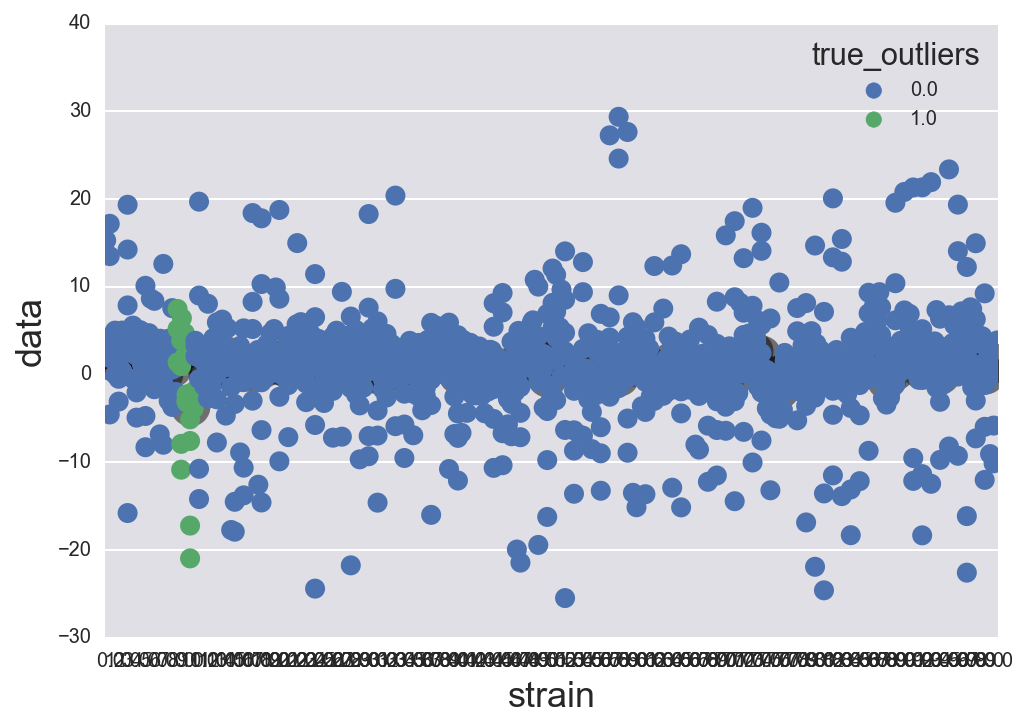

In [445]:
sns.swarmplot('strain', 'data', hue='true_outliers', data=df, size=10)
plt.axhline(df.data.mean(), ls='--', color='red')
plt.axhline(df.data.median(), ls='-.', color='green')
plt.plot(true_means, 'ko', alpha=0.5, ms=20)

In [430]:
stat_test_group = df.groupby(['strain'])

print('by strain')
for name, group in stat_test_group:
    gene = name
    gg = df[(df.strain == 1)].data
    if gene is not 1:
        x = df[(df.strain == gene)].data
        pval = stats.ttest_ind(gg, x, equal_var = False)[1]
        if pval < 0.05:
            print('{0}: pval = {1:2f}'.format(gene, pval))
            if pval*len(stat_test_group) < 0.1:
                print('{0} survived Bonferroni'.format(gene))

by strain
3.0: pval = 0.040772
9.0: pval = 0.000000
9.0 survived Bonferroni
12.0: pval = 0.040550
33.0: pval = 0.008166


In [300]:
#run the mcmc 
target = df.strain.unique()
p0, n_walkers, n_dim, locs_means, locs_gs = make_p0(target, df, 'strain', 'data')

In [301]:
sampler = hierarchical_mcmc(target, p0, n_walkers, locs_means, df, 'strain', 'data')

In [302]:
hypermean, sem, sigma, sigma_bad, s, means, g = hierarchical_unpacker(sampler,
                                                                      target,
                                                                      locs_means,
                                                                      locs_gs)

In [303]:
print("""
mean: {0:2f} +/- {1:2f}
sigma: {2:2f}
sigma_bad: {3:2f}
""".format(hypermean, sem, sigma, sigma_bad))


mean: 0.518799 +/- 0.012770
sigma: 2.213344
sigma_bad: 8.800739



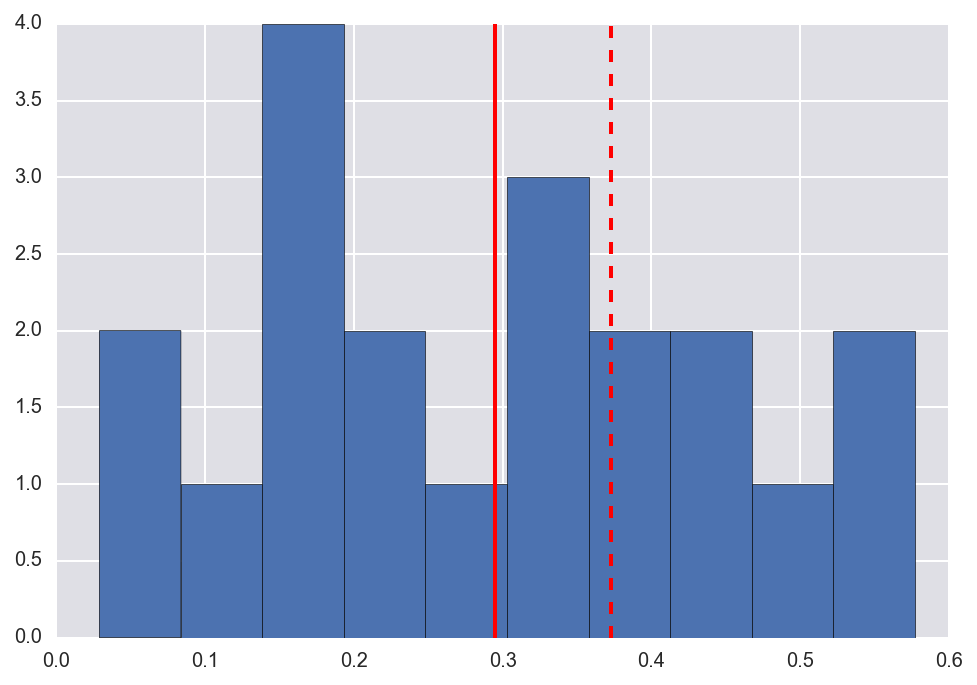

In [304]:
x = 1/2
# outliers = s >= s.mean() + x*s.std()
outliers = s > 0.5

plt.hist(s)
plt.axvline(s.mean(), color='r')
plt.axvline(s.mean()+ x*s.std(), ls='--', color='r')

In [305]:
def outy(x, array=outliers):
    ind = np.where(df.strain.unique() == x)
    return array[ind][0]
df['outliers'] = df.strain.apply(lambda x: outy(x))
df['mean_mcmc'] = df.strain.apply(lambda x: outy(x, array=means))


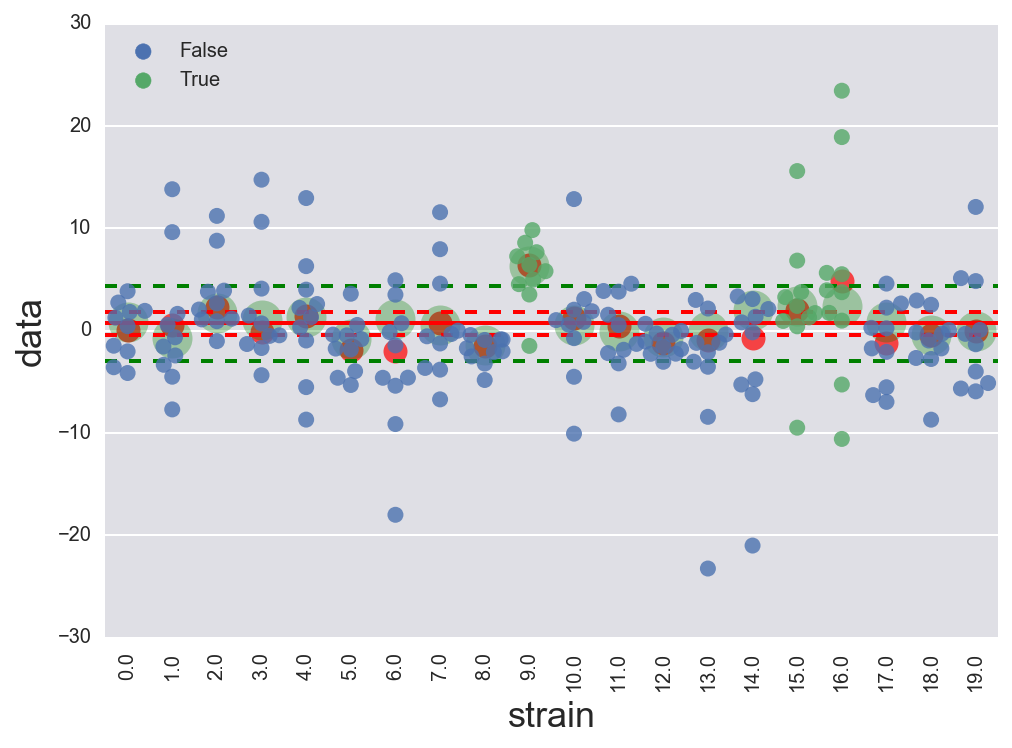

In [351]:
mean = sampler.flatchain[:, 0].mean()
sigma = sampler.flatchain[:, 1].mean()
sigma_bad = sampler.flatchain[:, 2].mean()


sns.swarmplot(x='strain', y='data', hue='outliers', size=8, data=df, alpha=0.8)
plt.plot(means, 'o', alpha=0.7, ms=12, color='r')
plt.plot(true_means, 'o', alpha=0.3, ms=20, color='g')

plt.axhline(mean, color='r')
plt.axhline(mean-sigma, color='r', ls='--')
plt.axhline(mean+sigma, color='r', ls='--')
plt.axhline(mean-sigma_bad, color='g', ls='--')
plt.axhline(mean+sigma_bad, color='g', ls='--')

plt.xticks(rotation=90)
plt.legend(loc='upper left')

/Users/dangeles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


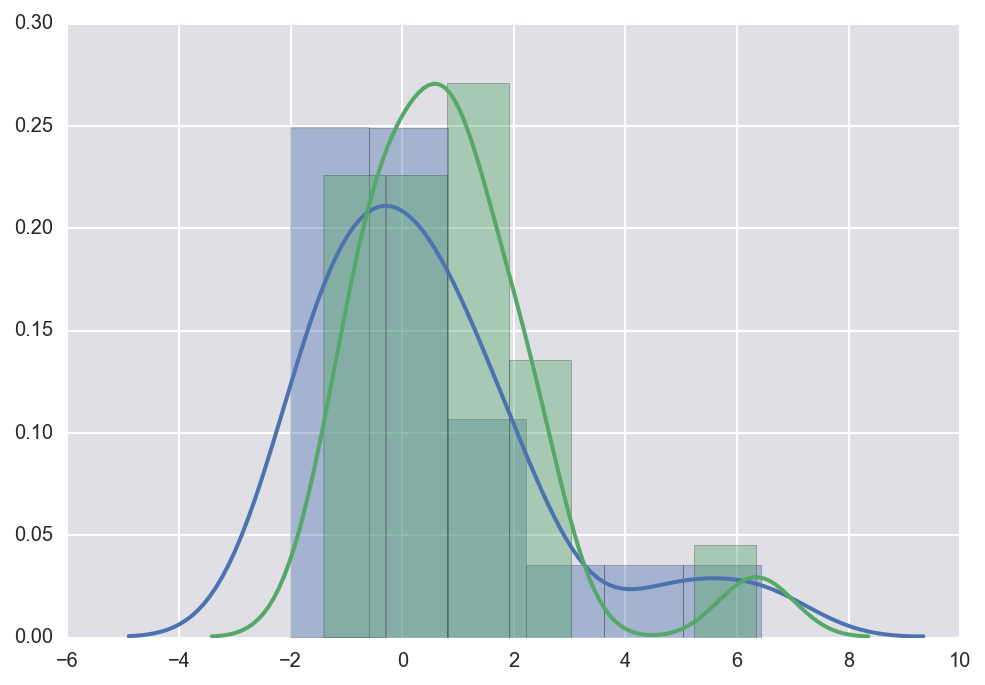

In [307]:
sns.distplot(df.mean_mcmc.unique())
sns.distplot(true_means)

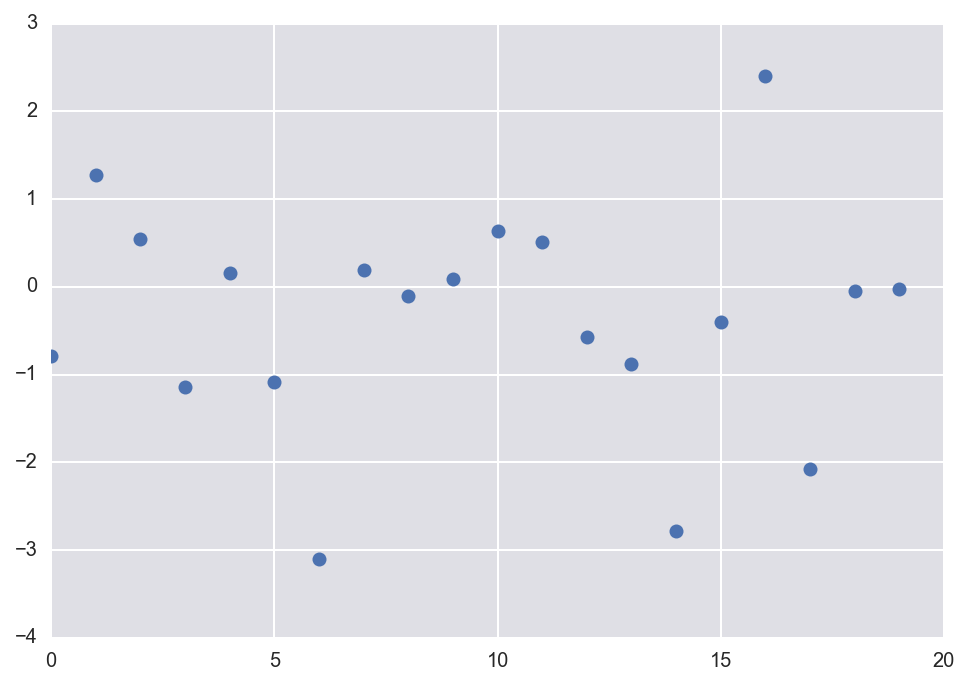

In [308]:
plt.plot(df.strain.unique(), (means-true_means), 'o')

In [309]:
means[10]

1.2269864107027721

In [310]:
true_means[9]+1

7.3449927410553588

In [311]:
sampler.acceptance_fraction

array([ 0.00333333,  0.00244444,  0.00277778, ...,  0.00322222,
        0.00222222,  0.003     ])

(array([   1.,    4.,   51.,  224.,  331.,  415.,  237.,   50.,   17.,    2.]),
 array([ 0.        ,  0.00053333,  0.00106667,  0.0016    ,  0.00213333,
         0.00266667,  0.0032    ,  0.00373333,  0.00426667,  0.0048    ,
         0.00533333]),
 <a list of 10 Patch objects>)

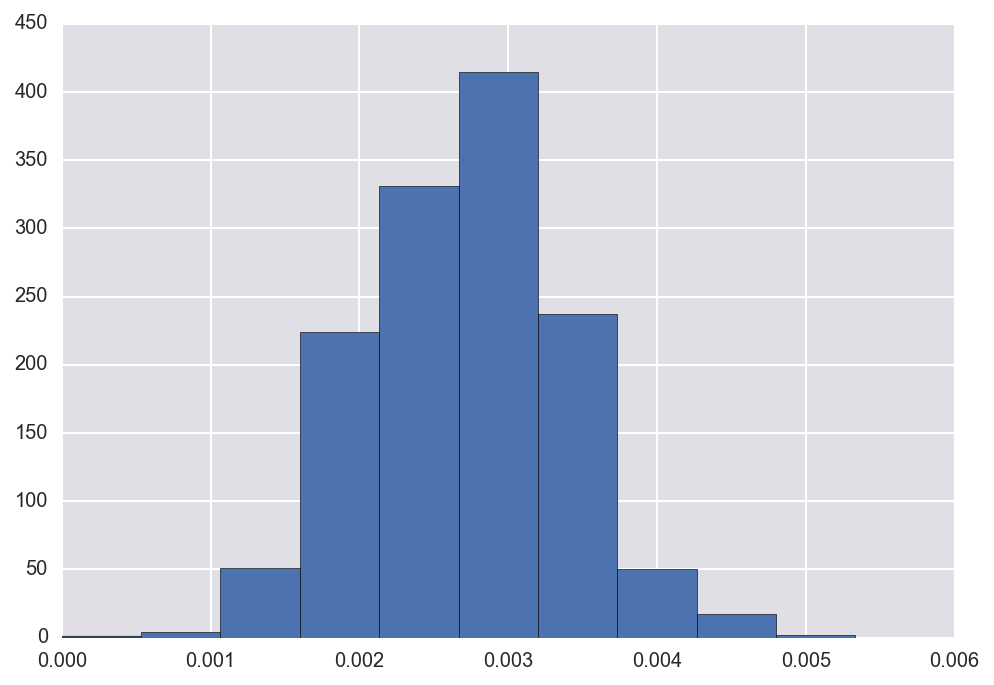

In [312]:
plt.hist(sampler.acceptance_fraction)

In [323]:
def mcmc(p0, n_walkers, data, n_burn=7000, n_steps=2000):
    """
    A wrapper around the emcee sampler for easy MCMCs.
    
    This wrapper function takes in a dataframe containing information
    on a few different genes. The user must specify which gene is 
    targeted, this gene is then analyzed using a good-bad posterior.
    params:
    -------
    target -- a string that specifies which gene to draw data from
    n_walkers -- number of walkers
    n_burn -- number of burn-in steps
    n_steps -- number of steps post-burn-in
    df -- the df to take data from
    """
    # Set up the EnsembleSampler instance
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, 
                                    log_posterior_good_bad_numba,
                                    args=(data,),
                                    threads=1, a=5)
    # Do the burn-in
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

    # Reset sampler and run from the burn-in state we got to
    _ = sampler.run_mcmc(pos, n_steps)
    
    return sampler

In [446]:
def make_p0_mcmc(data, n_burn=5000, n_steps=2000):
    n_dim = 3 + len(data)  # number of parameters in the model
    n_walkers = 200 + 4*n_dim
    
    # Seed random number generator for reproducibility
    np.random.seed(42)
    
    # Generate random starting points for walkers.
    # p0[i,j] is the starting point for walk i along variable j.
    p0 = np.empty((n_walkers, n_dim))
    
    x0= np.array([np.median(data), data.std()/2, data.std()*2])
    g0 = np.random.uniform(0, 1, len(data))
    for index, value in enumerate(data):
        zscore = (value - data.mean())/data.std()
        if np.abs(zscore) < 0.5:
            g0[index] = np.random.uniform(0, 0.3)
        elif np.abs(zscore) > 1:
            g0[index] = np.random.uniform(0.7, 1)
        else:
            g0[index] = np.random.uniform(0.3, 0.7)
    x0 = np.concatenate([x0, g0])
    res = scipy.optimize.minimize(neg_log_posterior_good_bad_numba, 
                                       x0, args=data, method='powell')
    
    #hyperparamters
    #optimize hyperparameters
    p0[:, 0] = np.random.normal(res.x[0], 0.05, n_walkers)  # mu
    p0[:, 1] = np.random.normal(res.x[1], 0.02, n_walkers) # sigma
    p0[:, 2] = np.random.normal(res.x[2], 0.02, n_walkers)  
        
    p0[p0[:, 1] < 0, 1] = res.x[1]
    p0[p0[:, 2] < 0, 2] = res.x[2]
        
    # there's a different number of data points for each assay so...
    for h in range(0, len(data)):
        g = np.random.normal(res.x[3 + h], 0.02, n_walkers)
        for l, g_l in enumerate(g):
            while g_l < 0 or g_l > 1:
                g_l = np.random.normal(res.x[3 + h], 0.02)
            g[l] = g_l
        p0[:, 3 + h] = g
        
    return p0, n_walkers, n_dim

In [447]:
p0, n_walkers, n_dim = make_p0_mcmc(true_means)
sampler = mcmc(p0, n_walkers, true_means)

/Users/dangeles/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/dangeles/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


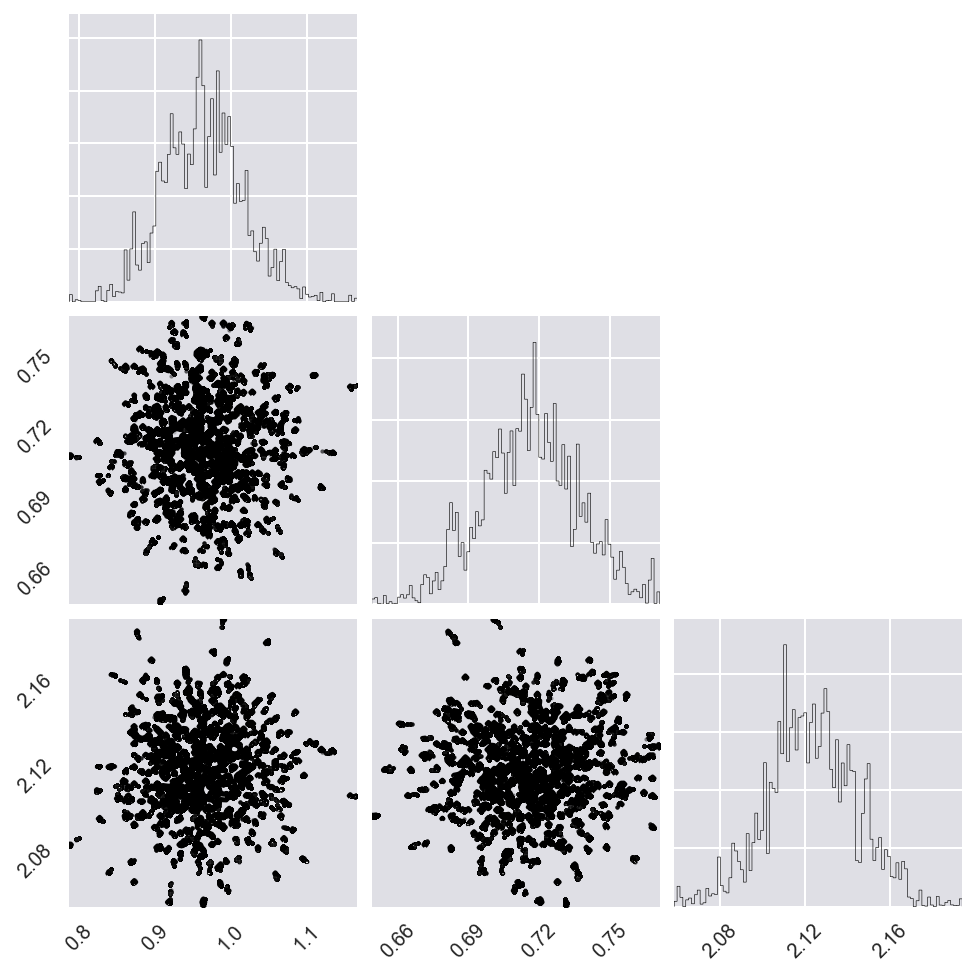

In [448]:
fig = corner.corner(sampler.flatchain[:, 0:3], bins=100)

/Users/dangeles/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/dangeles/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


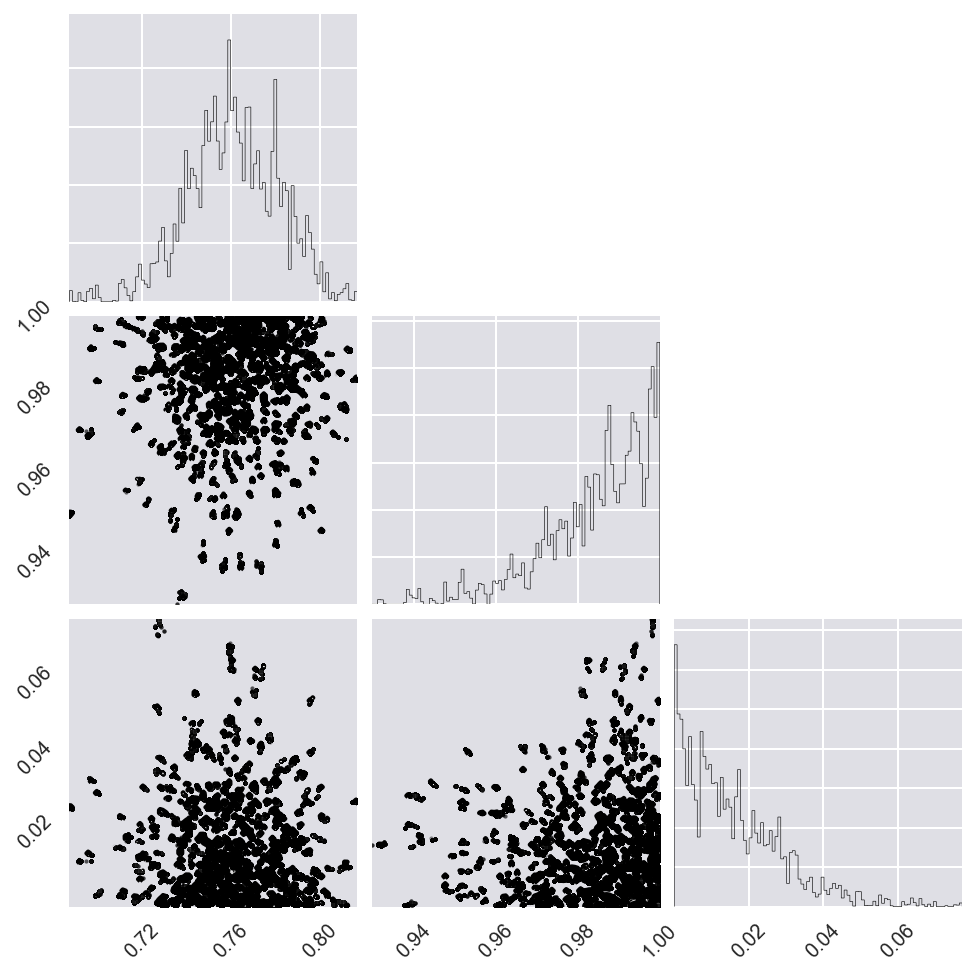

In [449]:
fig = corner.corner(sampler.flatchain[:, 11:14], bins=100)

In [450]:
print("""
mean: {0:2f}
sigma: {1:2f}
sigma_bad: {2:2f}
""".format(np.median(sampler.flatchain[:, 0]), sampler.flatchain[:, 1].mean(), 
           sampler.flatchain[:, 2].mean()))


mean: 0.961895
sigma: 0.716174
sigma_bad: 2.123171



In [451]:
true_means.mean()

1.0458073006898352

[False False  True False False False False False  True  True False False
 False False False False False False False False False  True False False
 False  True False False False  True False False False False False False
 False False False False False False False False False False False  True
 False False False False False False  True False False False False False
 False False  True False False False False False False False False False
  True False False  True False False False False False False False False
 False False False False False False  True False False False False False
  True False False False]


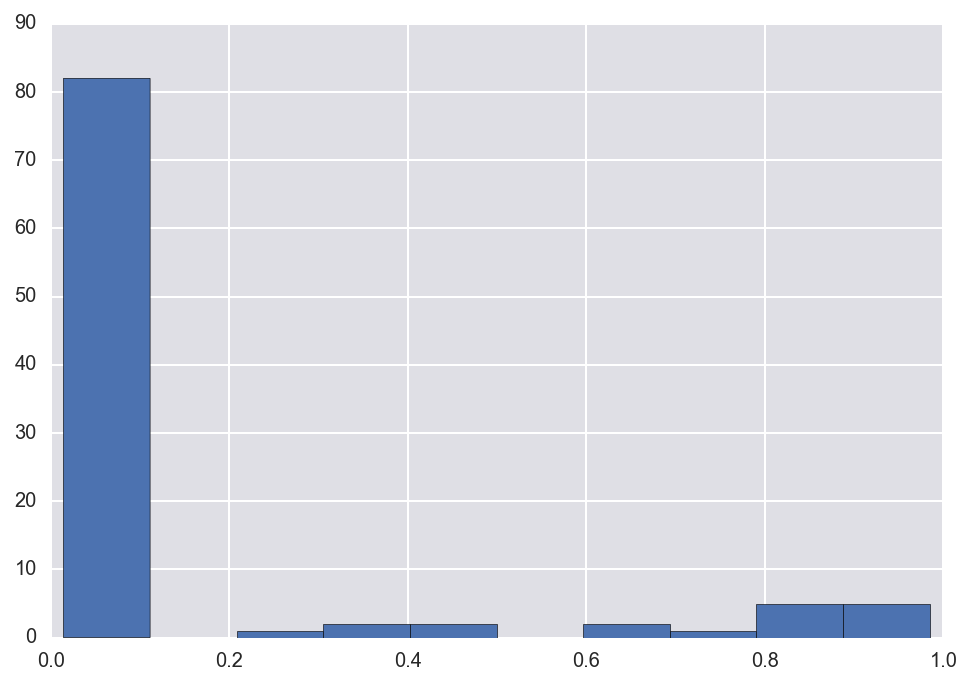

In [452]:
out = (sampler.flatchain[:, 3:].mean(axis=0))
plt.hist(out)
x = out > 0.5
print(x)

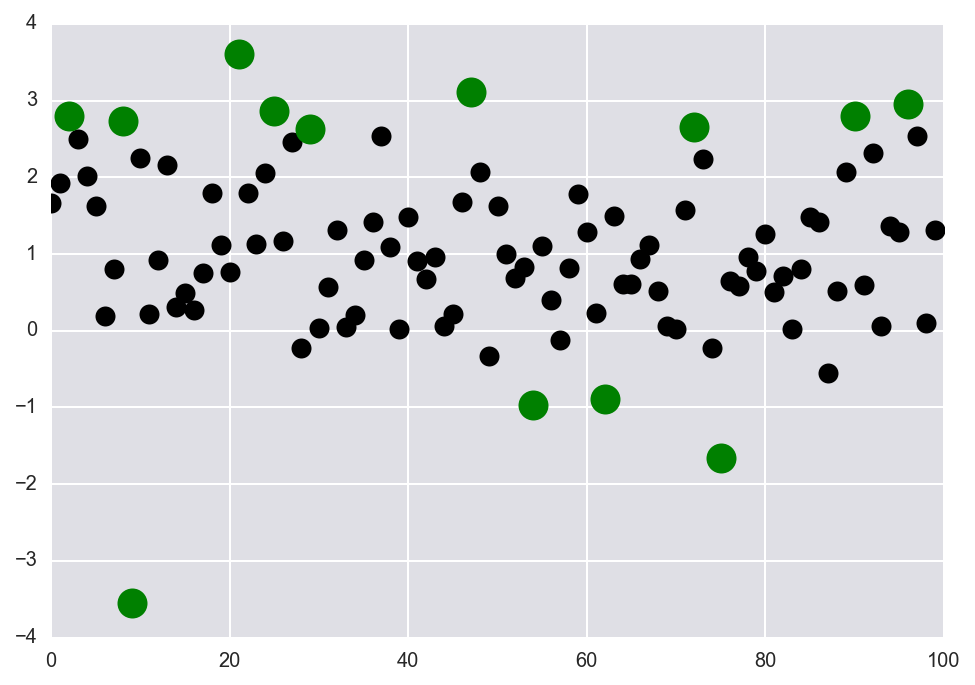

In [453]:
chi = df.strain.unique()
plt.plot(chi[~x], true_means[~x], 'ko', ms=10)
plt.plot(chi[x], true_means[x], 'go', ms=15)

(array([  15.,   46.,   84.,  125.,  145.,   92.,   64.,   29.,    9.,    3.]),
 array([ 0.00322222,  0.00378889,  0.00435556,  0.00492222,  0.00548889,
         0.00605556,  0.00662222,  0.00718889,  0.00775556,  0.00832222,
         0.00888889]),
 <a list of 10 Patch objects>)

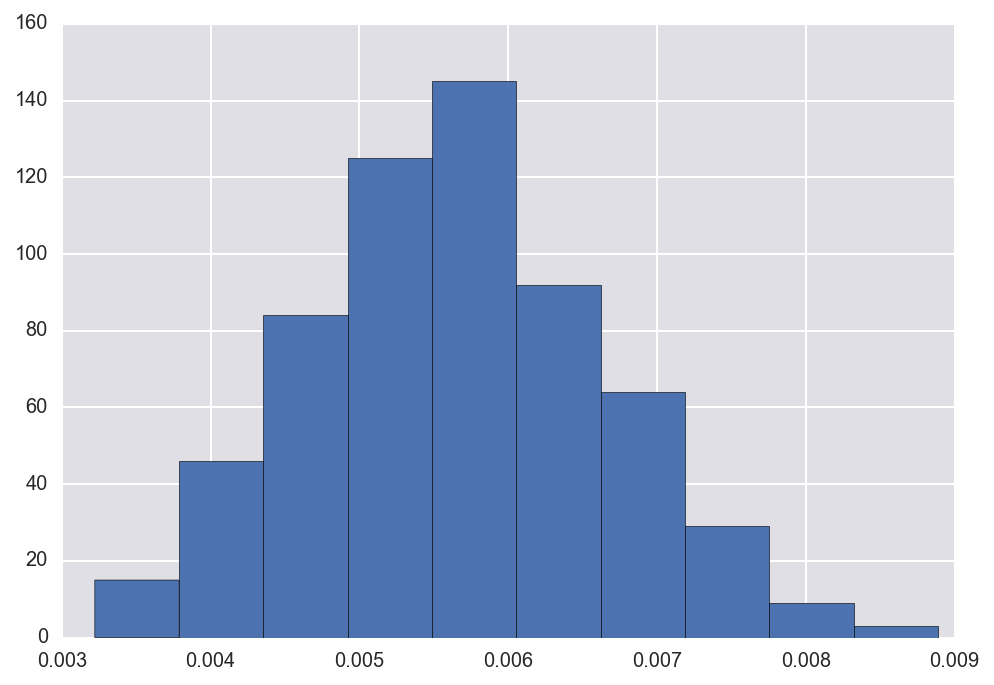

In [454]:
plt.hist(sampler.acceptance_fraction)